In [14]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from keras.callbacks import TensorBoard, ModelCheckpoint

In [2]:
# Loads the training and test data sets (ignoring class labels)
(x_train, _), (x_test, _) = mnist.load_data()

# Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))


In [3]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder.add(Flatten())
autoencoder.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)           0         
__________

In [4]:
# AutoEncoder의 중간 레이어 처리
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten_1').output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
Total para

In [5]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 49s 809us/step - loss: 0.2069 - val_loss: 0.1384
Epoch 2/10
60000/60000 [==============================] - 49s 817us/step - loss: 0.1266 - val_loss: 0.1176
Epoch 3/10
60000/60000 [==============================] - 48s 795us/step - loss: 0.1146 - val_loss: 0.1108
Epoch 4/10
60000/60000 [==============================] - 48s 796us/step - loss: 0.1095 - val_loss: 0.1067
Epoch 5/10
60000/60000 [==============================] - 48s 798us/step - loss: 0.1060 - val_loss: 0.1033
Epoch 6/10
60000/60000 [==============================] - 48s 798us/step - loss: 0.1033 - val_loss: 0.1013
Epoch 7/10
60000/60000 [==============================] - 48s 799us/step - loss: 0.1009 - val_loss: 0.0990
Epoch 8/10
60000/60000 [==============================] - 49s 817us/step - loss: 0.0989 - val_loss: 0.0967
Epoch 9/10
60000/60000 [==============================] - 48s 798us/step - loss: 0.0970 - val_

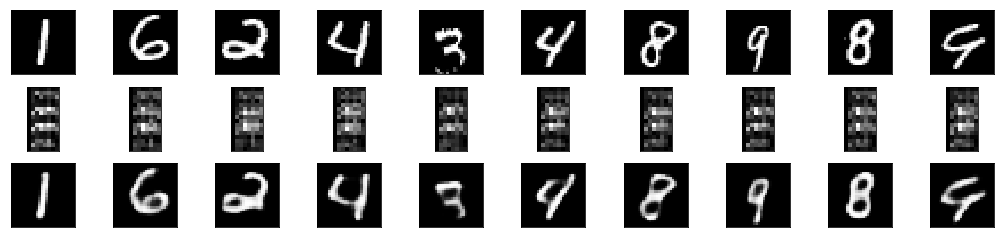

In [7]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 노이즈를 넣어보자

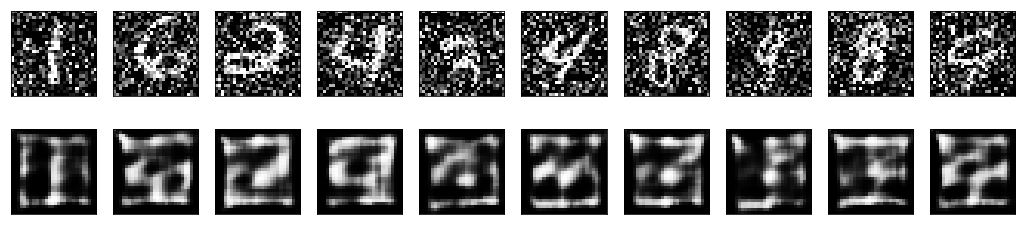

In [9]:
x_train_noisy = x_train + np.random.normal(loc=0.0, scale=0.5, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

x_test_noisy = x_test + np.random.normal(loc=0.0, scale=0.5, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

# Denoise test images
x_test_denoised = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(x_test_denoised[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 노이즈를 학습시키자 

In [16]:
tensorboard = TensorBoard(log_dir='/home/younseun/columbus_study/04_learning_tensorflow/07__abstractions/keras_20180926_tensorboard',
                         histogram_freq=0, write_graph=True, write_images=True)
model_saver = ModelCheckpoint(filepath='/home/younseun/columbus_study/04_learning_tensorflow/07__abstractions/keras_20180926_tensorboard/model',
                            verbose=0, period=2)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                validation_data=(x_test_noisy, x_test),
                callbacks=[tensorboard, model_saver])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 50s 828us/step - loss: 0.1180 - val_loss: 0.1164
Epoch 2/10
60000/60000 [==============================] - 49s 819us/step - loss: 0.1175 - val_loss: 0.1159
Epoch 3/10
60000/60000 [==============================] - 49s 823us/step - loss: 0.1171 - val_loss: 0.1159
Epoch 4/10
60000/60000 [==============================] - 50s 840us/step - loss: 0.1166 - val_loss: 0.1153
Epoch 5/10
60000/60000 [==============================] - 49s 821us/step - loss: 0.1163 - val_loss: 0.1147
Epoch 6/10
60000/60000 [==============================] - 50s 835us/step - loss: 0.1160 - val_loss: 0.1148
Epoch 7/10
60000/60000 [==============================] - 50s 831us/step - loss: 0.1157 - val_loss: 0.1146
Epoch 8/10
60000/60000 [==============================] - 49s 824us/step - loss: 0.1154 - val_loss: 0.1139
Epoch 9/10
60000/60000 [==============================] - 50s 828us/step - loss: 0.1151 - val_

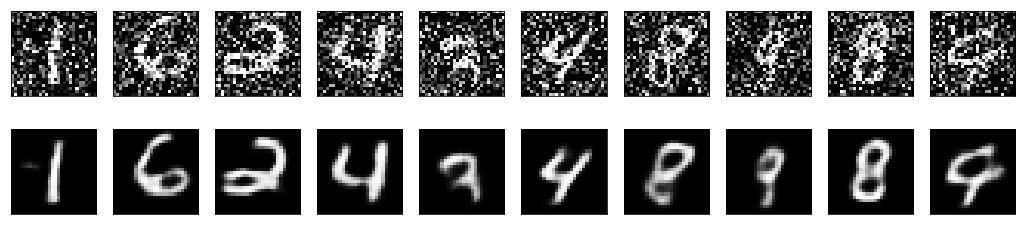

In [11]:
# Denoise test images
x_test_denoised = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(x_test_denoised[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 텐서보드 : younseun@younseun-dev:~/columbus_study/04_learning_tensorflow/07__abstractions/keras_20180926_tensorboard$ tensorboard --logdir=.